## 載入資料集

In [3]:
import pandas as pd

# 讀取資料集
df_train = pd.read_csv('https://raw.githubusercontent.com/andy6804tw/crazyai-xai/main/code/dataset/diabetes.csv')

# 查看資料筆數(row)與維度(col)
print(f'The shape of df_train: {df_train.shape}')

The shape of df_train: (768, 8)


## 切割訓練集與測試集

In [4]:
from sklearn.model_selection import train_test_split

x_feature_names = df_train.drop(['Outcome'], axis=1).columns
y_label_names = ['No', 'Yes']
X = df_train.drop(['Outcome'], axis=1).values # 移除y並取得剩下欄位資料
y = df_train['Outcome'].values # 取得病人糖尿病結果作為y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42, stratify=y)

print('train shape:', X_train.shape)
print('test shape:', X_test.shape)

train shape: (760, 7)
test shape: (8, 7)


## 訓練模型

In [5]:
from sklearn import svm

# 建立 kernel='linear' 模型
model=svm.SVC(kernel='linear', C=1, probability=True)
# 使用訓練資料訓練模型
model.fit(X_train, y_train)
# 計算準確率
print('訓練集準確率: ',model.score(X_train, y_train))
print('測試集準確率: ',model.score(X_test, y_test))

訓練集準確率:  0.7763157894736842
測試集準確率:  0.75


## SHAP 實作(KernelExplainer)

In [ ]:
!pip install -q shap

In [6]:
import shap

shap.initjs()

首先建立一個通用的 KernelExplainer 解釋器，並嘗試剖析剛剛所訓練的 SVM 分類模型。以下是常用的設定參數與說明：

Parameters:
- model：待解釋的模型。支援 sklearn 所封裝的模型，迴歸器可以使用 `model.predict`，分類器可以使用 `model.predict_proba`。
- data：可採樣的資料集，用於產生隨機擾動抽樣的子集，此資料用於訓練 SHAP 解釋模型。
- link：將SHAP簡單模型的預測輸出轉換為實際預測值的函數，提供兩種設定分別為 "identity" 和 "logit"。

以下程式放入已訓練的模型並呼叫 predict_proba 計算預測機率。而 data 從訓練集中拿前 50 筆出來，作為採樣的母群。採樣的數量 nsamples 數設為 100，即代表將透過蒙地卡羅法擾動從 data 中採樣 100 筆出來並訓練一個 SHAP 簡單的可解釋的模型。而每個隨機採樣的樣本(samples)需要對原始 50 筆資料進行隨機擾動與推論(取得 f() 預測 y)，因此總共需要 `500 * 50` 次模型推論來產生這 100 筆資料。然而 SHAP 官方建議 data 的資料量盡量不要超過 100 筆，以免會花費大量的計算成本。原始碼可以從這裡[參考](https://github.com/shap/shap/blob/1ccbf672399d3467e4e4433894ed00e4f067e258/shap/explainers/_kernel.py#L104)。

In [16]:
# 使用 Kernel SHAP 解釋模型
explainer = shap.KernelExplainer(model=model.predict_proba, data=X_train[:50], link='logit')

接著我們要使用 shap_values() 方法來估計 Shapely values 並對單筆資料進行解釋。以下是常用的設定參數與說明：

Parameters:
- X: 欲被解釋的資料。
- nsamples: 用於構建解釋每個預測的代理模型的樣本數量。

我們把之前先切割出來的測試集作為要被解釋的目標 Ｘ。接著設定 nsamples 為 100，這意味著我們將進行 100 次蒙地卡羅抽樣，從 KernelExplainer 設定的 data 中隨機擾動抽樣並建立一個 SHAP 簡單可解釋模型。對於每個隨機採樣的樣本，我們需要進行隨機擾動並進行模型推論（獲取 f() 的預測 y）。因此總共需要進行 `100*50` 次模型推論，以生成這 100 筆資料。然而 SHAP 官方建議盡量 data 的數量不要超過 100 筆數據，以避免過高的計算成本。原始碼可以從這裡[參考](https://github.com/shap/shap/blob/1ccbf672399d3467e4e4433894ed00e4f067e258/shap/explainers/_kernel.py#L104)。

In [17]:
shap_values = explainer.shap_values(X=X_test, nsamples=100)

  0%|          | 0/8 [00:00<?, ?it/s]

In [18]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 2
Shape of each element: (8, 7)


## 全局解釋模型
### SHAP Summary Plot
SHAP Summary Plot 可以幫助了解模型的特徵重要性，幫助解釋模型的預測。如果某個特徵的 SHAP 值較大且穩定，則可以認為該特徵對模型預測的影響較大且較一致。反之，如果特徵的 SHAP 值較小且不穩定，則可能認為該特徵對模型預測的影響較小或不一致。

- 點的顏色: Feature value 的大小，越紅越大、越藍越小
- X 軸: 該點對於 shap value 的影響，也就是對預測值的影響
- Y 軸: 每個特徵

我們可以使用 `plot_type` 參數設置 `bar` 畫一張條形圖，不同顏色代表不同類別(以下範例藍色代表預測Yes的重要程度，紅色為No)，每個條形代表一個特徵，並顯示該特徵對模型預測的影響程度。在這個圖表中，每個特徵對於各個類別的影響被堆疊起來，以創建整體的特徵重要性圖。

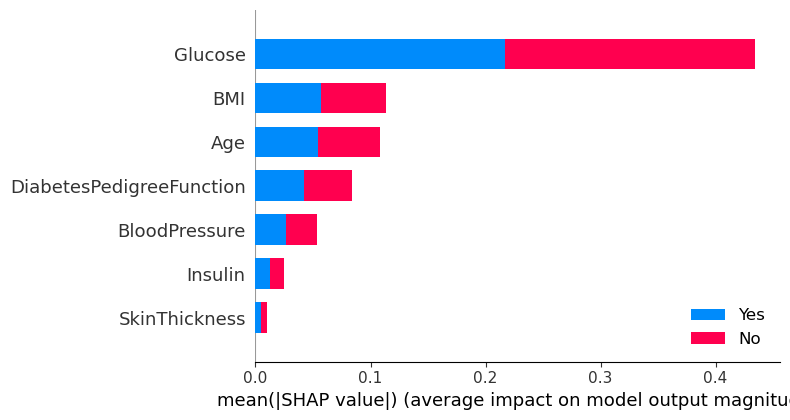

In [10]:
shap.summary_plot(shap_values, X_test, plot_type="bar", class_names= y_label_names, feature_names = x_feature_names)

我們也可以觀察特定類別的 summary_plot。假設我想看模型對於預測 Yes 的重要程度，可以使用 `shap_values[1]` 的資料取得每筆測試集的 Shapely values 進行全局的解釋。以下圖來說我們可以得知模型在判斷是否罹患糖尿病情況下大多會看葡萄糖濃度(Glucose)，當數值越大越有機會罹患糖尿病。第二個重要的特徵為年齡，同樣也是當年齡越大越有機會罹患糖尿病。

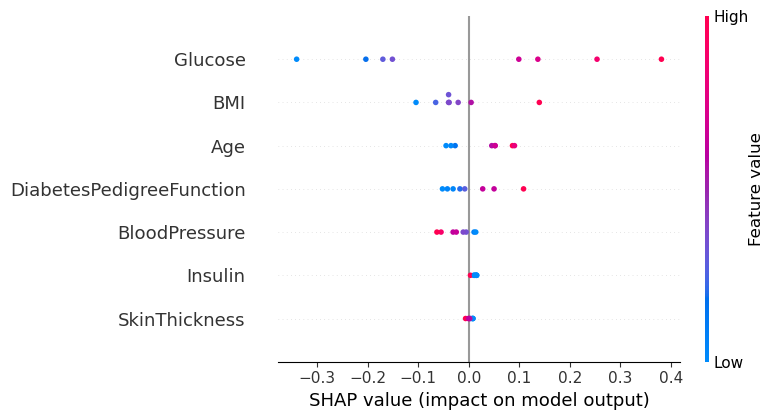

In [11]:
shap.summary_plot(shap_values[1], X_test, feature_names=x_feature_names)

### SHAP Dependence Plot
SHAP 相依圖是一種散點圖，顯示了單一特徵對模型所做預測的影響。在這個例子中，當每位葡萄糖濃度越高相對應的 Shapely values 逐漸增加。

- 每個點代表資料集中的一筆預測資料
- X 軸：該特徵的實際值
- Y 軸：該特徵的 SHAP 值，表示知道該特徵的值有多大程度上改變了該樣本預測的模型輸出。

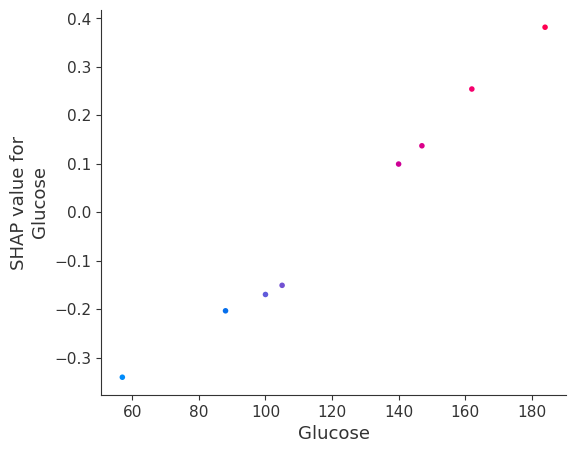

In [12]:
shap.dependence_plot('Glucose', shap_values[1], X_test, feature_names=x_feature_names)

SHAP 相依圖類似於部分相依圖，但考慮了特徵之間的交互作用，我們也可以觀察兩個變數的交互作用影響，可以在 `interaction_index` 參數中設定第二個特徵名稱，顏色對應到第二個特徵數值高低的影響。以下範例觀察BMI與皮脂厚度交互作用下對於 BMI 的 SHAP 值影響。

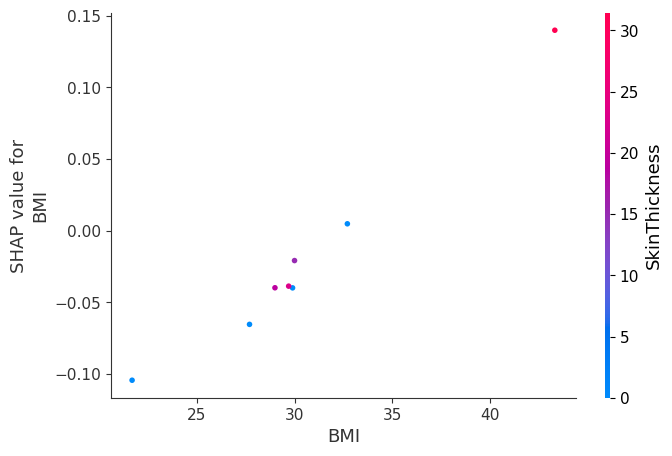

In [13]:
shap.dependence_plot('BMI', shap_values[1], X_test, feature_names=x_feature_names, interaction_index= 'SkinThickness')

## 局部解釋模型
### SHAP Force plot
我們可以觀察單一筆資料在模型中的預測情況。在 SHAP 套件中，「Force Plot」方法提供了針對單一模型預測的解釋性呈現。在這個圖表中，我們可以清楚地看到各特徵對模型對特定輸入值的預測所做的貢獻。這種方法在進行錯誤分析或深入理解特定情況下的資料時非常有幫助。

從以下圖表我們可以觀察：
1. 模型在測試集中的第一筆資料預測NO的機率有0.11，Yes的機率有0.89
2. base value: 代表模型在不看任何特徵狀況下預測的數值，在這個例子中，基準值 = 0.379。
3. 每個特徵後面的數字是該筆資料的特徵值，例如 Age 49 歲。
4. 紅色代表該特徵會增加判斷Yes的機率。而藍色代表該特徵會降低罹患糖尿病的機率。
5. 箭頭的寬度表示該特徵對輸出的影響越大。
6. Glucose、DiabetesPedigreeFunction、Age 這三個特徵明顯是判斷罹患糖尿病的重要因子。

In [ ]:
import numpy as np
x = explainer.expected_value[1]
x

In [20]:
shap.initjs()
# 觀察測試集中第一筆資料預測為Yes的重要程度
index=0
print(f'測試集第 {index+1} 筆模型預測結果: {model.predict_proba(X_test[[index], :])[0]}')
shap.force_plot(explainer.expected_value[1], shap_values[1][index], X_test[index], feature_names=x_feature_names, link='logit')

測試集第 1 筆模型預測結果: [0.1102278 0.8897722]


In [21]:
# https://github.com/shap/shap/blob/c8bae704f9d7703c47a916ec1d449a6d30441c4f/shap/common.py#L206C9-L206C9
x = sum(shap_values[1][index])+explainer.expected_value[1]
x

2.0884163520254306

In [22]:
shap.initjs()
# 觀察測試集中第一筆資料預測為No的重要程度
shap.force_plot(explainer.expected_value[0], shap_values[0][index], X_test[index], feature_names=x_feature_names)

In [23]:
x=sum(shap_values[0][index])+explainer.expected_value[0]
x

-2.0884163520254315

### SHAP waterfall plot

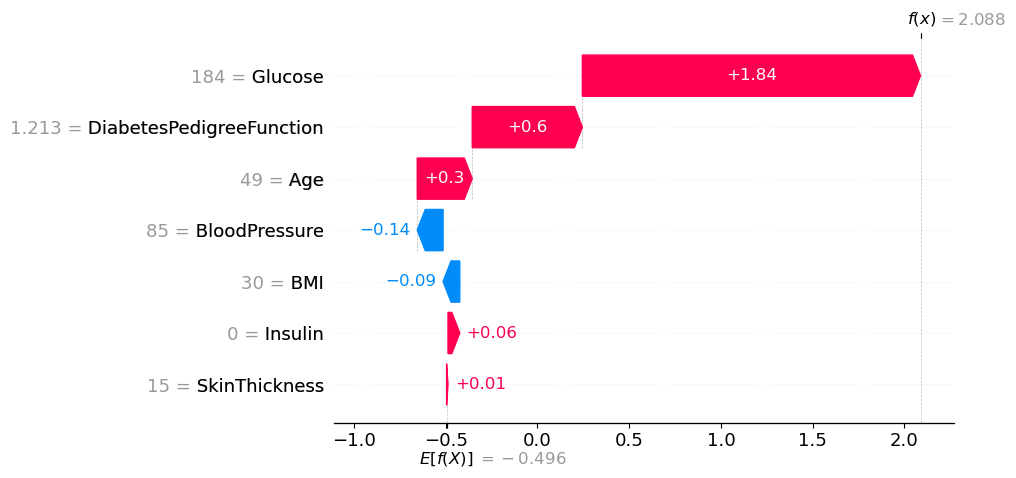

In [24]:
shap.waterfall_plot(shap.Explanation(values=shap_values[1][index], 
                                    base_values=explainer.expected_value[1], data=X_test[index],  
                                    feature_names=x_feature_names))